In [124]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from PIL import Image
from utils import mnist_reader
from sklearn.model_selection import train_test_split

class Dataset:
  def __init__(self, x, y, batch_size = 32):
    self.x = x
    self.y = y
    self.batch_size = batch_size
    self.length = int(np.ceil(x.shape[0]/batch_size))
    self.indices = np.arange(x.shape[0]) # 0, 1, 2, 3, 4, ..., n - 1

  def __getitem__(self, i): # i: 0, 1, 2, 3 ..., __len__
    i0 = i*self.batch_size
    i1 = min((i + 1)*self.batch_size, self.x.shape[0])
    index = self.indices[i0:i1]
    return self.x[index], self.y[index]

  def __len__(self):
    return self.length

  def shuffle(self):
    self.indices = np.random.permutation(self.indices)

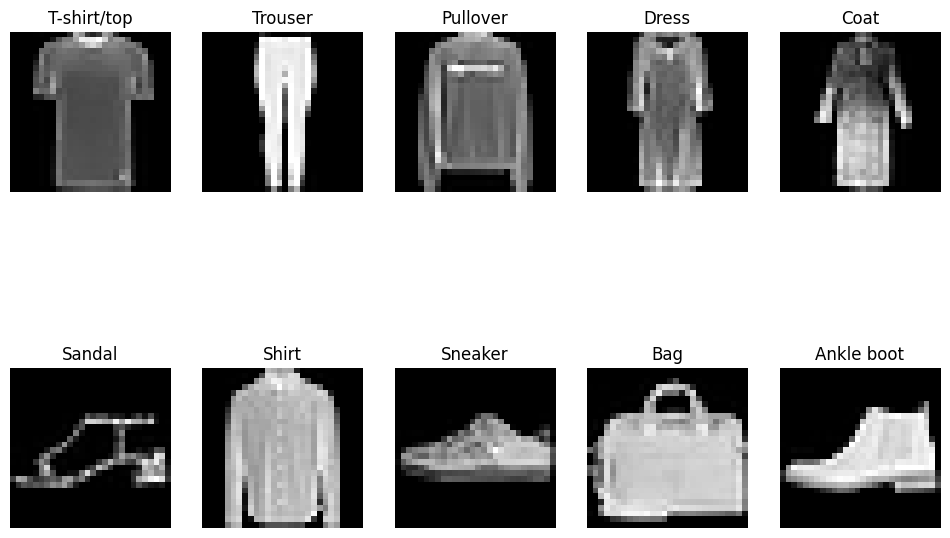

In [125]:
# Load Fashion-MNIST training data using utils.mnist_reader
train_images, train_labels = mnist_reader.load_mnist('data/fashion', kind='train')

# Normalize the training data to the range [0, 1]
train_images = train_images / 255.0

# Define the class labels for Fashion-MNIST
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualize one random sample from each class
plt.figure(figsize=(12, 8))
for i in range(10):
    # Filter samples for the current class
    class_samples = train_images[train_labels == i]

    # Randomly choose one sample from the current class
    random_index = np.random.randint(0, len(class_samples))
    random_sample = class_samples[random_index]

    # Reshape the sample to (28, 28) for plotting
    random_sample = np.reshape(random_sample, (28, 28))

    # Plot the sample
    plt.subplot(2, 5, i + 1)
    plt.imshow(random_sample, cmap='gray')
    plt.title(class_labels[i])
    plt.axis('off')

plt.show()

Training set shape: torch.Size([48000, 1, 28, 28])
Training labels shape: torch.Size([48000])
Validation set shape: torch.Size([12000, 1, 28, 28])
Validation labels shape: torch.Size([12000])


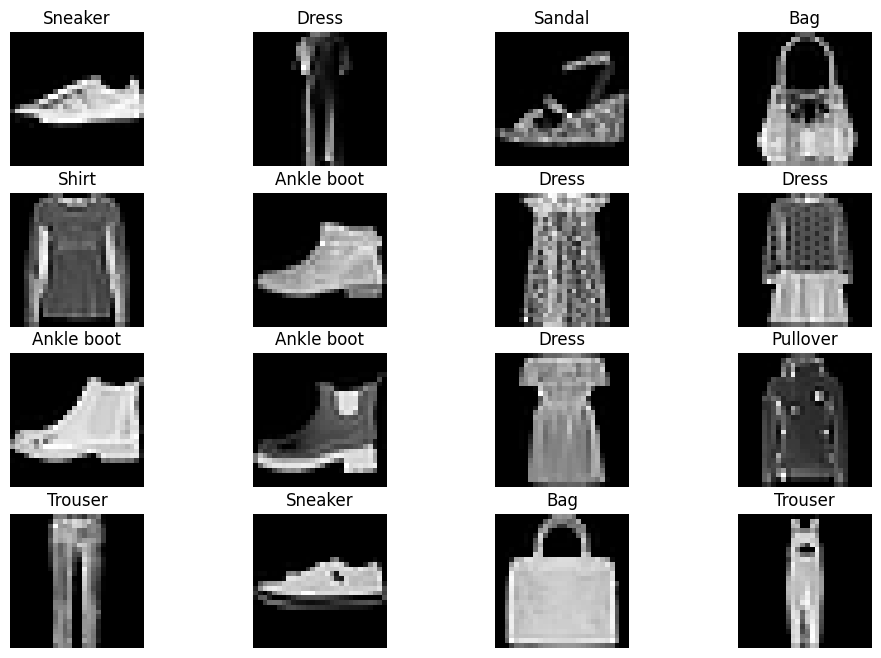

In [126]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Reshape the samples for both training and validation sets
train_images = train_images.reshape(-1, 1, 28, 28)
val_images = val_images.reshape(-1, 1, 28, 28)

# Convert NumPy arrays to PyTorch tensors
train_images = torch.Tensor(train_images)
train_labels = torch.LongTensor(train_labels)
val_images = torch.Tensor(val_images)
val_labels = torch.LongTensor(val_labels)

# Convert class labels to one-hot encodings
train_labels_onehot = torch.zeros(train_labels.size(0), 10)
train_labels_onehot.scatter_(1, train_labels.view(-1, 1), 1)
val_labels_onehot = torch.zeros(val_labels.size(0), 10)
val_labels_onehot.scatter_(1, val_labels.view(-1, 1), 1)

# Print the shapes of the subsets
print("Training set shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Validation set shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

# Create custom datasets using the provided Dataset class
train_dataset = Dataset(train_images, train_labels_onehot)
val_dataset = Dataset(val_images, val_labels_onehot)

batch_samples, batch_labels = train_dataset[0]

num_figures = 16
# Visualize the samples and corresponding class labels
plt.figure(figsize=(12, 8))
for i in range(num_figures):
    plt.subplot(4, 4, i + 1)
    sample_image = batch_samples[i][0].numpy()  # Access the first channel (single channel image)
    plt.imshow(sample_image, cmap='gray')
    #plt.title(f"Class: {torch.argmax(batch_labels[i]).item()}")
    plt.title(class_labels[torch.argmax(batch_labels[i])])
    plt.axis('off')
plt.show()

In [127]:
class Conv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        self.weight = torch.randn(out_channels, in_channels, kernel_size, kernel_size)
        self.bias = torch.zeros(out_channels)
        self.stride = stride

    #def forward(self, x):
    #    batch_size, in_channels, height, width = x.size()
    #    out_channels, _, kernel_size, _ = self.weight.size()

    #    # Calculate output dimensions
    #    out_height = (height - kernel_size) // self.stride + 1
    #    out_width = (width - kernel_size) // self.stride + 1

    #    # Initialize output tensor
    #    output = torch.zeros(batch_size, out_channels, out_height, out_width)

    #    # Perform convolution
    #    for i in range(out_height):
    #        for j in range(out_width):
    #            prvi = x[:, :, i * self.stride:i * self.stride + kernel_size, j * self.stride:j * self.stride + kernel_size]
    #            drugi = self.weight
    #            output[:, :, i, j] = torch.sum(torch.mul(prvi,drugi),dim=(2, 3)) + self.bias

    #    return output
    def forward(self, x):
        batch_size, in_channels, height, width = x.size()
        out_channels, _, kernel_size, _ = self.weight.size()

        # Calculate output dimensions
        out_height = (height - kernel_size) // self.stride + 1
        out_width = (width - kernel_size) // self.stride + 1

        # Unfold the input tensor
        unfolded_x = nn.functional.unfold(x, kernel_size, stride=self.stride)

        # Reshape the unfolded tensor to match weight dimensions
        unfolded_x = unfolded_x.view(batch_size, in_channels, kernel_size * kernel_size, out_height * out_width)

        # Reshape the weight tensor to (out_channels, in_channels * kernel_size * kernel_size)
        weight_reshaped = self.weight.view(out_channels, -1)

        # Perform convolution using matrix multiplication
        output = torch.matmul(weight_reshaped, unfolded_x).view(batch_size, out_channels, out_height, out_width) + self.bias.unsqueeze(-1).unsqueeze(-1)

        return output

class MaxPool2d(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        # Calculate output dimensions
        out_height = (height - self.kernel_size) // self.stride + 1
        out_width = (width - self.kernel_size) // self.stride + 1

        # Reshape the input tensor to make pooling efficient
        x_reshaped = x.view(batch_size, channels, out_height, self.stride, out_width, self.stride)

        # Take the maximum value along the last two dimensions
        pooled_values, _ = x_reshaped.max(dim=-1, keepdim=False)
        pooled_values, _ = pooled_values.max(dim=-2, keepdim=False)

        return pooled_values


class ReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # ReLU activation without using torch.nn.functional.relu
        return torch.max(torch.zeros_like(x), x)


In [128]:
# Create instances of custom and torch.nn modules
custom_conv = Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
torch_conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)

custom_maxpool = MaxPool2d(kernel_size=2, stride=2)
torch_maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

custom_relu = ReLU()
torch_relu = torch.nn.ReLU()

# Generate random input tensor
input_tensor = torch.randn(1, 1, 6, 6)

# Test Conv2d
# Copy weight and bias from custom implementation to torch.nn implementation
torch_conv.weight.data = custom_conv.weight
torch_conv.bias.data = custom_conv.bias
torch_conv_output = torch_conv(input_tensor)
custom_conv_output = custom_conv(input_tensor)
conv_diff = torch.abs(custom_conv_output - torch_conv_output).max().item()
print(conv_diff)

# Test MaxPool2d
custom_maxpool_output = custom_maxpool(custom_conv_output)
torch_maxpool_output = torch_maxpool(torch_conv_output)
maxpool_diff = torch.abs(custom_maxpool_output - torch_maxpool_output).max().item()
print(maxpool_diff)

# Test ReLU
custom_relu_output = custom_relu(custom_maxpool_output)
torch_relu_output = torch_relu(torch_maxpool_output)
relu_diff = torch.abs(custom_relu_output - torch_relu_output).max().item()
print(relu_diff)

# Check if maximal difference is smaller than 1e-5
if conv_diff < 1e-5 and maxpool_diff < 1e-5 and relu_diff < 1e-5:
    print("Custom implementations match torch.nn implementations.")
else:
    print("There is a mismatch between custom and torch.nn implementations.")

4.76837158203125e-07
2.384185791015625e-07
2.384185791015625e-07
Custom implementations match torch.nn implementations.


In [129]:
# Define the random input tensor
input_tensor = torch.rand(1, 100, 100) * 2 - 1  # Random elements in the range [-1, 1]

# Define the transformations
maxpool_relu_transform = torch.nn.Sequential(
    MaxPool2d(kernel_size=3, stride=2),
    ReLU()
)

relu_maxpool_transform = torch.nn.Sequential(
    ReLU(),
    MaxPool2d(kernel_size=3, stride=2)
)

# Apply the transformations
output_maxpool_relu = maxpool_relu_transform(input_tensor.unsqueeze(0).unsqueeze(0))  # Add batch and channel dimensions
output_relu_maxpool = relu_maxpool_transform(input_tensor.unsqueeze(0).unsqueeze(0))

# Convert tensors to images for visualization
to_pil = ToPILImage()
image_maxpool_relu = to_pil(output_maxpool_relu.squeeze())
image_relu_maxpool = to_pil(output_relu_maxpool.squeeze())

# Display the original and transformed images
plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.imshow(to_pil(input_tensor))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_maxpool_relu)
plt.title('MaxPool2d -> ReLU')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_relu_maxpool)
plt.title('ReLU -> MaxPool2d')
plt.axis('off')

plt.show()

ValueError: too many values to unpack (expected 4)